In [2]:
import pandas as pd

# Load core datasets
student_info = pd.read_csv("studentInfo.csv")         # demographics + outcome
student_vle = pd.read_csv("studentVLE.csv")           # VLE interactions
courses = pd.read_csv("courses.csv")                  # course presentation length (start/end)
vle = pd.read_csv("vle.csv")                          # learning resource types
assessments = pd.read_csv("assessments.csv")          # assessment timing (optional)

# Inspect
print(student_info.columns)
print(student_vle.columns)


Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result'],
      dtype='object')
Index(['code_module', 'code_presentation', 'id_student', 'id_site', 'date',
       'sum_click'],
      dtype='object')


In [3]:
# 1 = dropout (Withdrawn), 0 = passed or completed
student_info["event"] = student_info["final_result"].apply(lambda x: 1 if x == "Withdrawn" else 0)

# Estimate duration using last interaction date (in days)
vle_last_day = student_vle.groupby(
    ["id_student", "code_module", "code_presentation"]
)["date"].max().reset_index()

vle_last_day.columns = ["id_student", "code_module", "code_presentation", "last_interaction_day"]

# Merge into student_info
student_info = student_info.merge(
    vle_last_day, on=["id_student", "code_module", "code_presentation"], how="left"
)

# Assign duration:
# - Dropouts: last interaction day
# - Others: assume censored at max course length (269 days)
student_info["duration"] = student_info["last_interaction_day"].fillna(269)

# Drop helper column
student_info.drop(columns=["last_interaction_day"], inplace=True)


In [4]:
# Keep only interactions from days 0 to 35 (weeks 0–5)
early_vle = student_vle[student_vle["date"] <= 35]

# Quick look
early_vle.head()


,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [5]:
# Remove invalid negative dates (pre-course interactions)
student_vle = student_vle[student_vle["date"] >= 0]

# Now filter to early weeks: 0–5 = days 0 to 35
early_vle = student_vle[student_vle["date"] <= 35]

# Quick check
print(f"Filtered to {early_vle.shape[0]} early VLE records (0–35 days)")
early_vle.head()


Filtered to 2564918 early VLE records (0–35 days)


,code_module,code_presentation,id_student,id_site,date,sum_click
10847,AAA,2013J,345357,546667,0,3
10848,AAA,2013J,345357,546883,0,1
10849,AAA,2013J,345357,546732,0,14
10850,AAA,2013J,345357,546614,0,5
10851,AAA,2013J,345357,546876,0,1


In [6]:
# Group by student/module and engineer features
vle_features = early_vle.groupby(
    ["id_student", "code_module", "code_presentation"]
).agg(
    total_clicks=("sum_click", "sum"),
    mean_clicks=("sum_click", "mean"),
    std_clicks=("sum_click", "std"),
    active_days=("date", "nunique"),
    first_day=("date", "min"),
    last_day=("date", "max")
).reset_index()

# Add engagement window length
vle_features["engagement_span"] = vle_features["last_day"] - vle_features["first_day"]


In [7]:
# Merge aggregated VLE features with main student info
survival_df = student_info.merge(
    vle_features, on=["id_student", "code_module", "code_presentation"], how="left"
)

# Fill missing VLE engagement values (for students with no activity in weeks 0–5)
vle_cols = ["total_clicks", "mean_clicks", "std_clicks", "active_days", "first_day", "last_day", "engagement_span"]
survival_df[vle_cols] = survival_df[vle_cols].fillna(0)

# Final check
print("✅ survival_df shape:", survival_df.shape)
survival_df[["id_student", "code_module", "code_presentation", "duration", "event"] + vle_cols].head()


✅ survival_df shape: (32593, 21)


,id_student,code_module,code_presentation,duration,event,total_clicks,mean_clicks,std_clicks,active_days,first_day,last_day,engagement_span
0,11391,AAA,2013J,253.0,0,329.0,5.771930,10.753766,10.0,0.0,31.0,31.0
1,28400,AAA,2013J,239.0,0,410.0,3.727273,3.565660,15.0,0.0,34.0,34.0
2,30268,AAA,2013J,12.0,1,179.0,4.261905,4.231471,6.0,4.0,12.0,8.0
3,31604,AAA,2013J,264.0,0,397.0,3.176000,2.732906,22.0,1.0,34.0,33.0
4,32885,AAA,2013J,247.0,0,290.0,3.295455,3.231167,17.0,1.0,32.0,31.0


In [9]:
from sklearn.model_selection import train_test_split

# List of unique course modules
all_modules = survival_df["code_module"].unique()
print("All modules:", all_modules)

# Random 70/30 split of modules
train_modules, test_modules = train_test_split(all_modules, test_size=0.3, random_state=42)

# Select rows from survival_df based on those modules
train_df = survival_df[survival_df["code_module"].isin(train_modules)].copy()
test_df = survival_df[survival_df["code_module"].isin(test_modules)].copy()

print("Before leakage control:")
print(f"Train set: {train_df.shape}")
print(f"Test set: {test_df.shape}")


All modules: ['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
Before leakage control:
Train set: (16174, 21)
Test set: (16419, 21)


In [10]:
# Prevent student leakage
train_students = set(train_df["id_student"])
test_students = set(test_df["id_student"])

overlap = train_students.intersection(test_students)
print(f"Overlapping students: {len(overlap)}")

# Drop overlapping students from test set
test_df = test_df[~test_df["id_student"].isin(overlap)]

print("✅ After leakage removal:")
print(f"Train set: {train_df.shape}")
print(f"Test set: {test_df.shape}")


Overlapping students: 688
✅ After leakage removal:
Train set: (16174, 21)
Test set: (15692, 21)


In [11]:
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter

# 1. Define features
features = [
    "gender", "region", "highest_education", "age_band", "disability",
    "total_clicks", "mean_clicks", "std_clicks", "active_days", "engagement_span"
]

# 2. Preprocess function (dummy encoding)
def preprocess(df):
    df_model = df[features + ["duration", "event"]].copy()
    df_model = pd.get_dummies(df_model, columns=["gender", "region", "highest_education", "age_band", "disability"], drop_first=True)
    return df_model

X_train = preprocess(train_df)
X_test = preprocess(test_df)

# 3. Standardize numeric features
num_cols = ["total_clicks", "mean_clicks", "std_clicks", "active_days", "engagement_span"]
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [12]:
# 4. Fit Cox model
cph = CoxPHFitter()
cph.fit(X_train, duration_col="duration", event_col="event")

# Display model summary
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 16174 total observations, 10935 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 16174
number of events observed = 5239
   partial log-likelihood = -45836.61
         time fit was run = 2025-07-11 23:52:36 UTC

---
                                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                      
total_clicks                                  -0.47      0.63      0.05           -0.56           -0.38                0.57                0.69
mean_clicks                                    0.38      1.46      0.03            0.32            0.44                1.38                1.55
std_clicks                                    -0.12      0.88      0.04           -0.19           -0.05                0.83                0.95
active_days                                    0.05      1.05      0.04           -0.04            0.13                0.96                1.14
engagement_span                               -0.39      0.67      0.03           -0.45           -0.34                0.64                0.71
gender_M                                       0.22      1.24      0.03            0.16            0.28                1.17                1.32
region_East Midlands Region                    0.17      1.18      0.07            0.04            0.30                1.04                1.35
region_Ireland                                 0.28      1.32      0.10            0.08            0.48                1.08                1.62
region_London Region                           0.11      1.12      0.06           -0.01            0.23                0.99                1.26
region_North Region                            0.24      1.28      0.07            0.11            0.38                1.11                1.47
region_North Western Region                    0.18      1.19      0.06            0.05            0.30                1.06                1.34
region_Scotland                                0.04      1.04      0.06           -0.08            0.16                0.92                1.18
region_South East Region                       0.10      1.11      0.07           -0.03            0.24                0.97                1.27
region_South Region                            0.03      1.03      0.06           -0.10            0.15                0.91                1.17
region_South West Region                       0.12      1.12      0.07           -0.01            0.25                0.99                1.28
region_Wales                                   0.36      1.43      0.08            0.21            0.51                1.23                1.66
region_West Midlands Region                    0.25      1.28      0.06            0.12            0.38                1.13                1.46
region_Yorkshire Region                        0.19      1.21      0.07            0.05            0.33                1.05                1.39
highest_education_HE Qualification             0.11      1.11      0.04            0.02            0.19                1.02                1.21
highest_education_Lower Than A Level           0.04      1.04      0.03           -0.02            0.10                0.98                1.10
highest_education_No Formal quals              0.27      1.31      0.12            0.03            0.52                1.03                1.68
highest_education_Post Graduate Qualification  0.03      1.03      0.13           -0.23            0.30                0.79                1.35
age_band_35-55                                -0.07      0.93      0.03           -0.13           -0.00                0.88                1.00
age_band_55<=                 

In [13]:
# 5. Concordance index (ranking accuracy)
train_c_index = cph.concordance_index_
test_c_index = cph.score(X_test, scoring_method="concordance_index")

print(f"✅ Concordance Index (Train): {train_c_index:.4f}")
print(f"✅ Concordance Index (Test):  {test_c_index:.4f}")


✅ Concordance Index (Train): 0.6590
✅ Concordance Index (Test):  0.6292


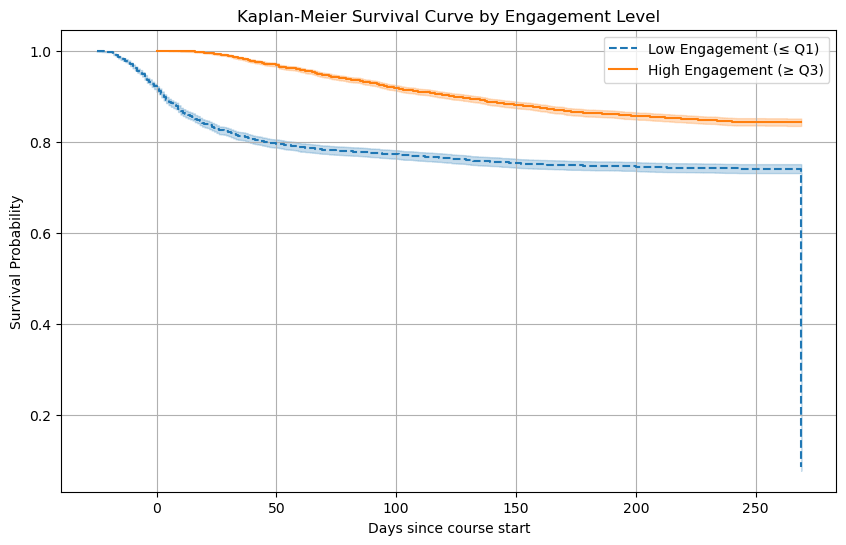

In [14]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# 1. Define quartile-based engagement groups
q75 = survival_df["total_clicks"].quantile(0.75)
q25 = survival_df["total_clicks"].quantile(0.25)

low_engaged = survival_df[survival_df["total_clicks"] <= q25]
high_engaged = survival_df[survival_df["total_clicks"] >= q75]

# 2. Fit KM models
kmf_low = KaplanMeierFitter()
kmf_high = KaplanMeierFitter()

# 3. Plot survival curves
plt.figure(figsize=(10,6))

kmf_low.fit(low_engaged["duration"], event_observed=low_engaged["event"], label="Low Engagement (≤ Q1)")
kmf_low.plot(ci_show=True, linestyle="--")

kmf_high.fit(high_engaged["duration"], event_observed=high_engaged["event"], label="High Engagement (≥ Q3)")
kmf_high.plot(ci_show=True)

plt.title("Kaplan-Meier Survival Curve by Engagement Level")
plt.xlabel("Days since course start")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


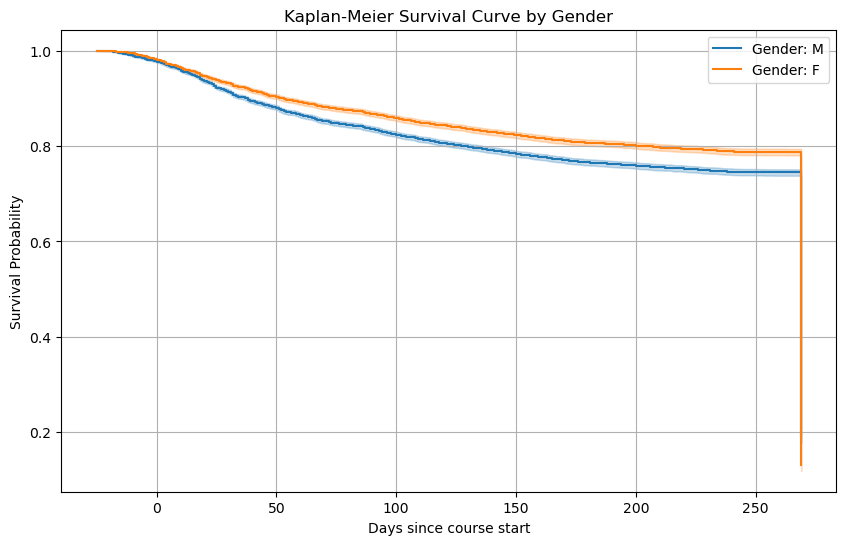

In [15]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Create separate KM curves for each gender
kmf = KaplanMeierFitter()

plt.figure(figsize=(10,6))

for gender_value in survival_df["gender"].unique():
    group = survival_df[survival_df["gender"] == gender_value]
    kmf.fit(group["duration"], event_observed=group["event"], label=f"Gender: {gender_value}")
    kmf.plot(ci_show=True)

plt.title("Kaplan-Meier Survival Curve by Gender")
plt.xlabel("Days since course start")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


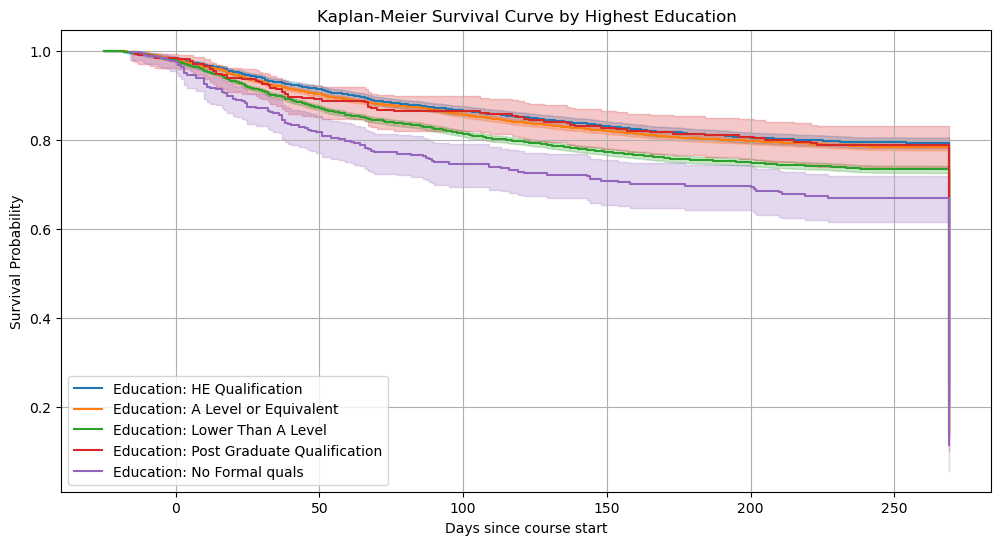

In [16]:
plt.figure(figsize=(12,6))

for edu_level in survival_df["highest_education"].unique():
    group = survival_df[survival_df["highest_education"] == edu_level]
    kmf.fit(group["duration"], event_observed=group["event"], label=f"Education: {edu_level}")
    kmf.plot(ci_show=True)

plt.title("Kaplan-Meier Survival Curve by Highest Education")
plt.xlabel("Days since course start")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


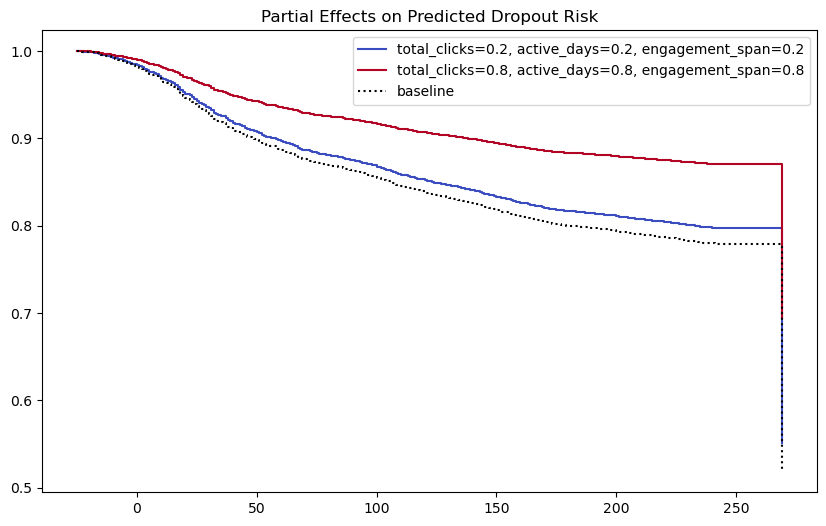

In [17]:
# Partial effect plots for top 10 features (ranked by effect size)
cph.plot_partial_effects_on_outcome(covariates=["total_clicks", "active_days", "engagement_span"], 
                                     values=[[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]],
                                     cmap="coolwarm",
                                     figsize=(10,6))
plt.title("Partial Effects on Predicted Dropout Risk")
plt.show()


In [18]:
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler
import numpy as np

# List of modules to treat as folds
modules = survival_df["code_module"].unique()
concordances = []

for test_mod in modules:
    # Split: one module for test, rest for train
    train_df = survival_df[survival_df["code_module"] != test_mod].copy()
    test_df = survival_df[survival_df["code_module"] == test_mod].copy()

    # Remove any overlapping students
    train_ids = set(train_df["id_student"])
    test_df = test_df[~test_df["id_student"].isin(train_ids)]

    # Preprocess features
    def preprocess(df):
        df_model = df[features + ["duration", "event"]].copy()
        df_model = pd.get_dummies(df_model, columns=["gender", "region", "highest_education", "age_band", "disability"], drop_first=True)
        return df_model

    X_train = preprocess(train_df)
    X_test = preprocess(test_df)

    # Align columns in case some dummies are missing in test
    missing_cols = set(X_train.columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0
    X_test = X_test[X_train.columns]

    # Standardize numeric columns
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    # Fit Cox model
    cph = CoxPHFitter()
    cph.fit(X_train, duration_col="duration", event_col="event")

    # Score on test set
    c_index = cph.score(X_test, scoring_method="concordance_index")
    concordances.append(c_index)

    print(f"✅ Module {test_mod}: C-index = {c_index:.4f}")

# Report average performance
print(f"\n✅ Average C-index across modules: {np.mean(concordances):.4f}")


✅ Module AAA: C-index = 0.5657
✅ Module BBB: C-index = 0.6219
✅ Module CCC: C-index = 0.6765
✅ Module DDD: C-index = 0.6724
✅ Module EEE: C-index = 0.7178
✅ Module FFF: C-index = 0.6798
✅ Module GGG: C-index = 0.5843

✅ Average C-index across modules: 0.6455


In [19]:
import pandas as pd

# Construct module-wise C-index DataFrame
cv_results = pd.DataFrame({
    "code_module": ["AAA", "BBB", "CCC", "DDD", "EEE", "FFF", "GGG"],
    "c_index": [0.5657, 0.6219, 0.6765, 0.6724, 0.7178, 0.6798, 0.5843]
})

# Add average row (optional)
cv_results.loc[len(cv_results.index)] = ["Average", cv_results["c_index"].mean()]

# Save to CSV
cv_results.to_csv("coxph_cv_results_by_module.csv", index=False)

print("✅ Module-wise concordance scores saved to 'coxph_cv_results_by_module.csv'")


✅ Module-wise concordance scores saved to 'coxph_cv_results_by_module.csv'


#Explore module aaa

In [20]:
# Extract only students from AAA
aaa_df = survival_df[survival_df["code_module"] == "AAA"].copy()

# Dropout rate
dropout_rate = aaa_df["event"].mean()
print(f"📉 Dropout rate in AAA: {dropout_rate:.2%}")
print(f"📦 Number of students in AAA: {len(aaa_df)}")

# Feature distribution (summary stats)
aaa_df[["total_clicks", "mean_clicks", "std_clicks", "active_days", "engagement_span"]].describe()


📉 Dropout rate in AAA: 16.84%
📦 Number of students in AAA: 748


,total_clicks,mean_clicks,std_clicks,active_days,engagement_span
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,412.705882,3.576428,3.765765,16.061497,27.844920
std,418.526294,1.265312,2.067098,9.268794,9.134281
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,148.000000,2.896247,2.737187,9.000000,26.000000
50%,306.500000,3.539649,3.569472,15.000000,32.000000
75%,526.000000,4.209772,4.504873,23.000000,34.000000
max,3626.000000,10.449568,31.351983,36.000000,35.000000


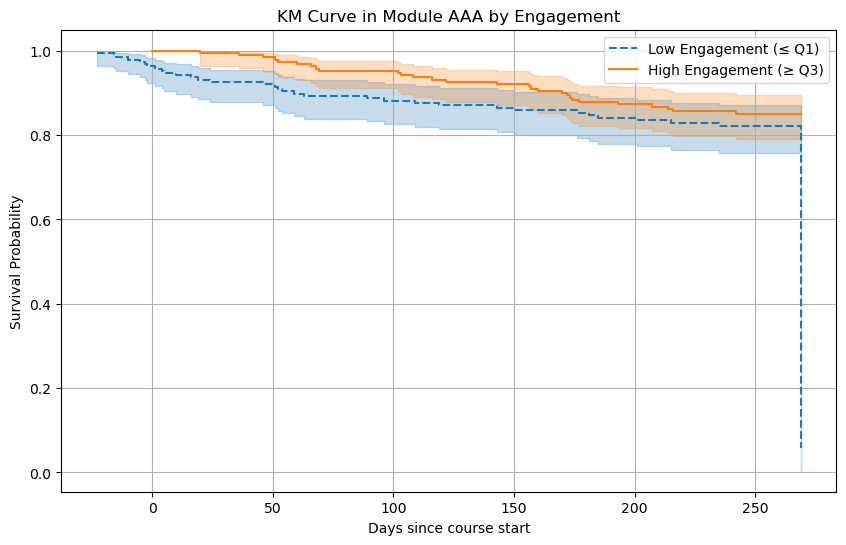

In [21]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Quartile thresholds within AAA
q75 = aaa_df["total_clicks"].quantile(0.75)
q25 = aaa_df["total_clicks"].quantile(0.25)

low_eng = aaa_df[aaa_df["total_clicks"] <= q25]
high_eng = aaa_df[aaa_df["total_clicks"] >= q75]

# Plot KM survival
kmf = KaplanMeierFitter()

plt.figure(figsize=(10,6))
kmf.fit(low_eng["duration"], low_eng["event"], label="Low Engagement (≤ Q1)")
kmf.plot(ci_show=True, linestyle="--")

kmf.fit(high_eng["duration"], high_eng["event"], label="High Engagement (≥ Q3)")
kmf.plot(ci_show=True)

plt.title("KM Curve in Module AAA by Engagement")
plt.xlabel("Days since course start")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


Compare AAA vs. EEE Side-by-Side

In [22]:
# Filter both modules
eee_df = survival_df[survival_df["code_module"] == "EEE"].copy()

# Dropout rates
dropout_aaa = aaa_df["event"].mean()
dropout_eee = eee_df["event"].mean()

print(f"📉 Dropout Rate - AAA: {dropout_aaa:.2%} | Students: {len(aaa_df)}")
print(f"📉 Dropout Rate - EEE: {dropout_eee:.2%} | Students: {len(eee_df)}")

# Feature comparison
print("\n📊 Mean Total Clicks (Early Weeks):")
print(f"AAA: {aaa_df['total_clicks'].mean():.1f}")
print(f"EEE: {eee_df['total_clicks'].mean():.1f}")


📉 Dropout Rate - AAA: 16.84% | Students: 748
📉 Dropout Rate - EEE: 24.61% | Students: 2934

📊 Mean Total Clicks (Early Weeks):
AAA: 412.7
EEE: 353.8


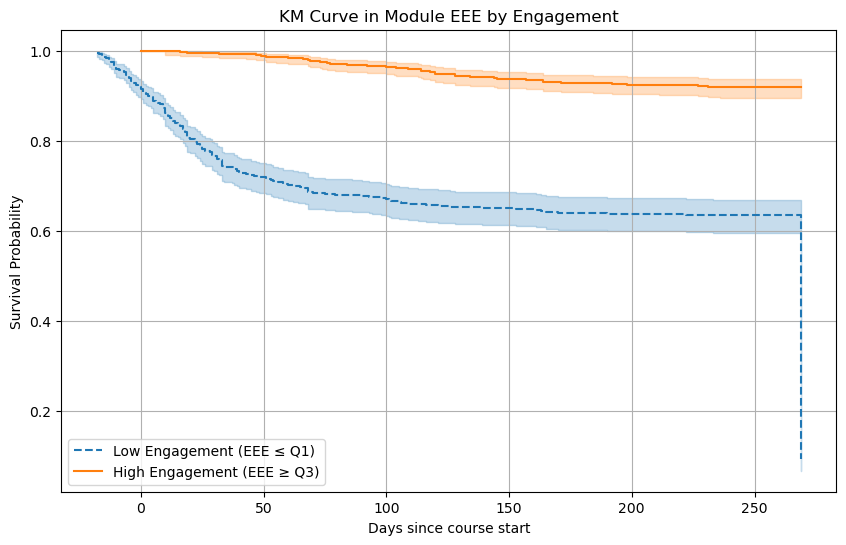

In [23]:
# Define quartiles in EEE
q75_eee = eee_df["total_clicks"].quantile(0.75)
q25_eee = eee_df["total_clicks"].quantile(0.25)

low_eng_eee = eee_df[eee_df["total_clicks"] <= q25_eee]
high_eng_eee = eee_df[eee_df["total_clicks"] >= q75_eee]

# KM plot
kmf = KaplanMeierFitter()
plt.figure(figsize=(10,6))

kmf.fit(low_eng_eee["duration"], low_eng_eee["event"], label="Low Engagement (EEE ≤ Q1)")
kmf.plot(ci_show=True, linestyle="--")

kmf.fit(high_eng_eee["duration"], high_eng_eee["event"], label="High Engagement (EEE ≥ Q3)")
kmf.plot(ci_show=True)

plt.title("KM Curve in Module EEE by Engagement")
plt.xlabel("Days since course start")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


time varying covariates

In [24]:
# Filter studentVLE to days 0–41 to cover full weeks 0–5
vle_weekly = student_vle[(student_vle["date"] >= 0) & (student_vle["date"] <= 41)].copy()

# Map date to week number (0-based)
vle_weekly["week"] = vle_weekly["date"] // 7

# Sum clicks per student/module/week
weekly_clicks = vle_weekly.groupby(["id_student", "code_module", "code_presentation", "week"])["sum_click"].sum().reset_index()
weekly_clicks.rename(columns={"sum_click": "clicks"}, inplace=True)

# Expand to all weeks (0–5), even if no activity
full_weeks = pd.MultiIndex.from_product([
    student_info["id_student"].unique(),
    student_info["code_module"].unique(),
    student_info["code_presentation"].unique(),
    range(6)
], names=["id_student", "code_module", "code_presentation", "week"]).to_frame(index=False)

weekly_df = pd.merge(full_weeks, weekly_clicks, on=["id_student", "code_module", "code_presentation", "week"], how="left")
weekly_df["clicks"] = weekly_df["clicks"].fillna(0)


In [25]:
# Merge student survival info
weekly_df = weekly_df.merge(
    student_info[["id_student", "code_module", "code_presentation", "duration", "event"]],
    on=["id_student", "code_module", "code_presentation"],
    how="left"
)

# Compute (start, stop) intervals in days
weekly_df["start"] = weekly_df["week"] * 7
weekly_df["stop"] = weekly_df["start"] + 7

# Filter to rows within student's duration
weekly_df = weekly_df[weekly_df["start"] < weekly_df["duration"]].copy()
weekly_df["stop"] = weekly_df[["stop", "duration"]].min(axis=1)

# Set event = 1 only in final interval
weekly_df["event_at_stop"] = ((weekly_df["stop"] == weekly_df["duration"]) & (weekly_df["event"] == 1)).astype(int)


In [26]:
# Preview first few rows
weekly_df[["id_student", "start", "stop", "clicks", "event_at_stop"]].head()


,id_student,start,stop,clicks,event_at_stop
0,11391,0,7.0,183.0,0
1,11391,7,14.0,20.0,0
2,11391,14,21.0,100.0,0
3,11391,21,28.0,0.0,0
4,11391,28,35.0,26.0,0


In [27]:
# Merge demographics (time-invariant covariates)
demographics = student_info[[
    "id_student", "code_module", "code_presentation",
    "gender", "region", "highest_education", "age_band", "disability"
]]

weekly_df = weekly_df.merge(demographics, on=["id_student", "code_module", "code_presentation"], how="left")

# One-hot encode categorical variables (drop_first avoids multicollinearity)
weekly_df = pd.get_dummies(
    weekly_df,
    columns=["gender", "region", "highest_education", "age_band", "disability"],
    drop_first=True
)


In [28]:
# Rename required columns
weekly_df = weekly_df.rename(columns={
    "id_student": "id",
    "event_at_stop": "event"
})

# Sanity check
weekly_df[["id", "start", "stop", "clicks", "event"]].head()


,id,start,stop,clicks,event,event
0,11391,0,7.0,183.0,0.0,0
1,11391,7,14.0,20.0,0.0,0
2,11391,14,21.0,100.0,0.0,0
3,11391,21,28.0,0.0,0.0,0
4,11391,28,35.0,26.0,0.0,0


In [29]:
# Check column names
print(weekly_df.columns)


Index(['id', 'code_module', 'code_presentation', 'week', 'clicks', 'duration',
       'event', 'start', 'stop', 'event', 'gender_M',
       'region_East Midlands Region', 'region_Ireland', 'region_London Region',
       'region_North Region', 'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification', 'age_band_35-55',
       'age_band_55<=', 'disability_Y'],
      dtype='object')


In [30]:
# Drop the incorrect 'event' column from student_info merge
weekly_df = weekly_df.drop(columns=["event"])  # drop the conflicting one

# Now rename the correct one
weekly_df = weekly_df.rename(columns={"event_at_stop": "event"})


In [31]:
print([col for col in weekly_df.columns if "event" in col])


[]


In [32]:
from lifelines import CoxTimeVaryingFitter

# Recreate the list of covariates
model_cols = ["id", "start", "stop", "event", "clicks"] + \
             [col for col in weekly_df.columns if col.startswith(('gender_', 'region_', 'highest_education_', 'age_band_', 'disability_'))]

# Final dataset for modeling
tv_df = weekly_df[model_cols].copy()

# Fit the model
ctv = CoxTimeVaryingFitter()
ctv.fit(tv_df, id_col="id", start_col="start", stop_col="stop", event_col="event")

# View summary
ctv.print_summary()


KeyError: "['event'] not in index"

In [33]:
# Check which event-like columns still exist
print([col for col in weekly_df.columns if 'event' in col])


[]


In [34]:
# Sanity check: ensure you still have original event and duration columns
assert "duration" in weekly_df.columns
assert "event" not in weekly_df.columns  # we are going to recreate it

# Bring in original dropout indicator from student_info
event_map = student_info[["id_student", "code_module", "code_presentation", "event"]]

# Rename for clarity
event_map = event_map.rename(columns={"id_student": "id", "event": "original_event"})

# Merge original event info back
weekly_df = weekly_df.merge(event_map, on=["id", "code_module", "code_presentation"], how="left")

# Recreate correct event column (event only at final interval)
weekly_df["event"] = ((weekly_df["stop"] == weekly_df["duration"]) & (weekly_df["original_event"] == 1)).astype(int)

# Final check
print(weekly_df[["id", "start", "stop", "clicks", "event"]].head())


      id  start  stop  clicks  event
0  11391      0   7.0   183.0      0
1  11391      7  14.0    20.0      0
2  11391     14  21.0   100.0      0
3  11391     21  28.0     0.0      0
4  11391     28  35.0    26.0      0


In [4]:
# Load VLE interaction data if not already done
student_vle = pd.read_csv("studentVLE.csv")
student_info = pd.read_csv("studentInfo.csv")

# Filter to relevant range (only valid dates)
student_vle = student_vle[student_vle["date"] >= 0]

# Compute first and last VLE date per student
vle_agg = student_vle.groupby("id_student")["date"].agg(["min", "max"]).reset_index()
vle_agg.columns = ["id_student", "first_day", "last_day"]
vle_agg["duration"] = vle_agg["last_day"]

# Merge into student_info
student_info = student_info.merge(vle_agg[["id_student", "duration"]], on="id_student", how="left")

# Define 'event': dropout = 1 if final_result is not 'Pass' or 'Distinction'
student_info["event"] = student_info["final_result"].apply(lambda x: 1 if x in ["Withdrawn", "Fail"] else 0)

# ✅ Check columns
print(student_info[["id_student", "duration", "event"]].head())


   id_student  duration  event
0       11391     253.0      0
1       28400     239.0      0
2       30268      12.0      1
3       31604     264.0      0
4       32885     247.0      0


In [6]:
# Generate time-varying intervals
base_df = student_info[["id_student", "code_module", "code_presentation", "duration", "event"]].copy()
base_df = base_df.rename(columns={"id_student": "id"})

rows = []
for _, row in base_df.iterrows():
    weeks = int(np.ceil(row["duration"] / 7))
    for w in range(weeks):
        start = w * 7
        stop = min(start + 7, row["duration"])
        event = int((stop == row["duration"]) and row["event"] == 1)
        rows.append({
            "id": row["id"],
            "code_module": row["code_module"],
            "code_presentation": row["code_presentation"],
            "start": start,
            "stop": stop,
            "event": event
        })

tv_base_df = pd.DataFrame(rows)
print(tv_base_df.head())


ValueError: cannot convert float NaN to integer

#Removing students with missing duration

In [7]:
# Drop students with no duration (i.e., no VLE interaction)
base_df = student_info[["id_student", "code_module", "code_presentation", "duration", "event"]].copy()
base_df = base_df.dropna(subset=["duration"])  # ✅ this is the key fix
base_df = base_df.rename(columns={"id_student": "id"})

# Rebuild time-varying rows
rows = []
for _, row in base_df.iterrows():
    weeks = int(np.ceil(row["duration"] / 7))
    for w in range(weeks):
        start = w * 7
        stop = min(start + 7, row["duration"])
        event = int((stop == row["duration"]) and row["event"] == 1)
        rows.append({
            "id": row["id"],
            "code_module": row["code_module"],
            "code_presentation": row["code_presentation"],
            "start": start,
            "stop": stop,
            "event": event
        })

tv_base_df = pd.DataFrame(rows)
print(tv_base_df.head())
print(f"\n✅ Generated {len(tv_base_df):,} time-varying records for {base_df.shape[0]} students.")


      id code_module code_presentation  start  stop  event
0  11391         AAA             2013J      0   7.0      0
1  11391         AAA             2013J      7  14.0      0
2  11391         AAA             2013J     14  21.0      0
3  11391         AAA             2013J     21  28.0      0
4  11391         AAA             2013J     28  35.0      0

✅ Generated 800,086 time-varying records for 29129 students.


Merge in Weekly VLE Clicks

In [8]:
# Step 1: Create a 'week' column in student_vle
student_vle["week"] = (student_vle["date"] // 7).astype(int)

# Step 2: Aggregate total clicks per student per week
clicks_per_week = student_vle.groupby(["id_student", "code_module", "code_presentation", "week"])["sum_click"].sum().reset_index()
clicks_per_week = clicks_per_week.rename(columns={
    "id_student": "id",
    "week": "start",
    "sum_click": "clicks"
})

# Step 3: Merge with the time-varying base frame
tv_df = tv_base_df.merge(clicks_per_week, on=["id", "code_module", "code_presentation", "start"], how="left")

# Step 4: Fill missing click values with 0
tv_df["clicks"] = tv_df["clicks"].fillna(0)

# ✅ Preview
print(tv_df.head())
print(f"\n✅ Final time-varying dataset shape: {tv_df.shape}")


      id code_module code_presentation  start  stop  event  clicks
0  11391         AAA             2013J      0   7.0      0   183.0
1  11391         AAA             2013J      7  14.0      0    20.0
2  11391         AAA             2013J     14  21.0      0    27.0
3  11391         AAA             2013J     21  28.0      0     1.0
4  11391         AAA             2013J     28  35.0      0     0.0

✅ Final time-varying dataset shape: (800086, 7)


Merge Static Covariates (Demographics)

In [9]:
# Step 1: Select relevant static features
static_covariates = student_info[[
    "id_student", "gender", "region", "highest_education", "age_band", "disability"
]].copy()
static_covariates = static_covariates.rename(columns={"id_student": "id"})

# Step 2: Merge static covariates into time-varying frame
tv_df = tv_df.merge(static_covariates, on="id", how="left")

# Step 3: One-hot encode categorical variables (drop_first avoids collinearity)
tv_df = pd.get_dummies(tv_df, columns=[
    "gender", "region", "highest_education", "age_band", "disability"
], drop_first=True)

# ✅ Done
print(tv_df.head())
print(f"\n✅ Time-varying dataset is ready for modeling. Final shape: {tv_df.shape}")


      id code_module code_presentation  start  stop  event  clicks  gender_M  \
0  11391         AAA             2013J      0   7.0      0   183.0      True   
1  11391         AAA             2013J      7  14.0      0    20.0      True   
2  11391         AAA             2013J     14  21.0      0    27.0      True   
3  11391         AAA             2013J     21  28.0      0     1.0      True   
4  11391         AAA             2013J     28  35.0      0     0.0      True   

   region_East Midlands Region  region_Ireland  ...  region_Wales  \
0                        False           False  ...         False   
1                        False           False  ...         False   
2                        False           False  ...         False   
3                        False           False  ...         False   
4                        False           False  ...         False   

   region_West Midlands Region  region_Yorkshire Region  \
0                        False               

In [11]:
from lifelines import CoxTimeVaryingFitter

# Drop string columns before fitting
tv_numeric = tv_df.drop(columns=["id", "code_module", "code_presentation"])

# Reattach 'id' column separately (needed for grouping)
tv_numeric["id"] = tv_df["id"]

# Fit CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter()
ctv.fit(tv_numeric, id_col="id", start_col="start", stop_col="stop", event_col="event", show_progress=True)

# Print summary
ctv.print_summary()


Iteration 1: norm_delta = 3.28e-01, step_size = 0.9500, log_lik = -185559.12848, newton_decrement = 1.01e+03, seconds_since_start = 5.0
Iteration 2: norm_delta = 3.42e-01, step_size = 0.9500, log_lik = -184477.13753, newton_decrement = 2.67e+02, seconds_since_start = 9.4
Iteration 3: norm_delta = 4.36e-01, step_size = 0.9500, log_lik = -184137.95902, newton_decrement = 1.47e+02, seconds_since_start = 13.9
Iteration 4: norm_delta = 3.75e-01, step_size = 0.9310, log_lik = -183957.36657, newton_decrement = 4.87e+01, seconds_since_start = 18.3
Iteration 5: norm_delta = 1.79e-01, step_size = 0.9124, log_lik = -183901.90373, newton_decrement = 6.81e+00, seconds_since_start = 22.8
Iteration 6: norm_delta = 4.43e-02, step_size = 1.0000, log_lik = -183894.75202, newton_decrement = 2.78e-01, seconds_since_start = 27.2
Iteration 7: norm_delta = 1.17e-03, step_size = 1.0000, log_lik = -183894.46914, newton_decrement = 1.83e-04, seconds_since_start = 31.7
Iteration 8: norm_delta = 7.71e-07, step_si

<lifelines.CoxTimeVaryingFitter: fitted with 1023018 periods, 25469 subjects, 18562 events>
         event col = 'event'
number of subjects = 25469
 number of periods = 1023018
  number of events = 18562
partial log-likelihood = -183894.47
  time fit was run = 2025-07-15 16:15:27 UTC

---
                                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                      
clicks                                        -0.04      0.96      0.00           -0.04           -0.04                0.96                0.96
gender_M                                       0.04      1.04      0.02            0.01            0.07                1.01                1.07
region_East Midlands Region                    0.08      1.09      0.04            0.01            0.15                1.01                1.17
region_Ireland                                -0.05      0.95      0.05           -0.14            0.04                0.87                1.04
region_London Region                           0.22      1.24      0.03            0.15            0.28                1.17                1.33
region_North Region                            0.01      1.02      0.04           -0.06            0.09                0.94                1.10
region_North Western Region                    0.21      1.24      0.03            0.15            0.28                1.16                1.32
region_Scotland                                0.14      1.16      0.03            0.08            0.21                1.08                1.23
region_South East Region                      -0.03      0.97      0.04           -0.11            0.04                0.90                1.05
region_South Region                           -0.07      0.93      0.03           -0.14           -0.01                0.87                0.99
region_South West Region                       0.03      1.03      0.04           -0.05            0.10                0.96                1.10
region_Wales                                   0.25      1.28      0.04            0.18            0.32                1.19                1.38
region_West Midlands Region                    0.13      1.14      0.04            0.06            0.20                1.06                1.22
region_Yorkshire Region                        0.13      1.14      0.04            0.06            0.21                1.06                1.23
highest_education_HE Qualification            -0.12      0.88      0.02           -0.17           -0.07                0.84                0.93
highest_education_Lower Than A Level           0.38      1.46      0.02            0.35            0.41                1.41                1.51
highest_education_No Formal quals              0.67      1.95      0.06            0.54            0.79                1.72                2.21
highest_education_Post Graduate Qualification -0.18      0.84      0.08           -0.34           -0.02                0.71                0.98
age_band_35-55                                -0.17      0.84      0.02           -0.21           -0.14                0.81                0.87
age_band_55<=                                 -0.30      0.74      0.10           -0.49           -0.11                0.61                0.89
disability_Y                                   0.27      1.31      0.02            0.22            0.31                1.25                1.37

                                               cmp to      z      p  -log2(p)
covariate                                                                    
clicks                                           0.00 -25.64 <0.005    479.22
gender_M                                         0.00   2.41   0.02      5.99
region_East Midlands Region                      0.00   2.27   0.02      5.43
region_

🔍 Quick Interpretation of Key Outputs
🔹 Strongest Risk Factors for Dropout (↑ hazard)
| Feature                                | Hazard Ratio (exp(coef)) | Interpretation                                           |
| -------------------------------------- | ------------------------ | -------------------------------------------------------- |
| `highest_education_No Formal quals`    | 1.95                     | Nearly **2x higher dropout hazard**                      |
| `disability_Y`                         | 1.31                     | 31% higher hazard for students with disabilities         |
| `region_Wales`                         | 1.28                     | Regional risk variation — Wales has significantly ↑ risk |
| `highest_education_Lower Than A Level` | 1.46                     | 46% higher hazard than the reference group               |

🔹 Protective Factors (↓ hazard)
| Feature                              | Hazard Ratio | Interpretation                                      |
| ------------------------------------ | ------------ | --------------------------------------------------- |
| `age_band_55<=`                      | 0.74         | Older students have **26% lower** dropout hazard    |
| `highest_education_Post Graduate`    | 0.84         | PG students are less likely to drop out             |
| `highest_education_HE Qualification` | 0.88         | Also protective compared to baseline                |
| `clicks`                             | 0.96         | Each extra weekly click **reduces** hazard slightly |


1. Plot Partial Effects (Top Features)
Let’s visualize the top 15 features with largest impact:


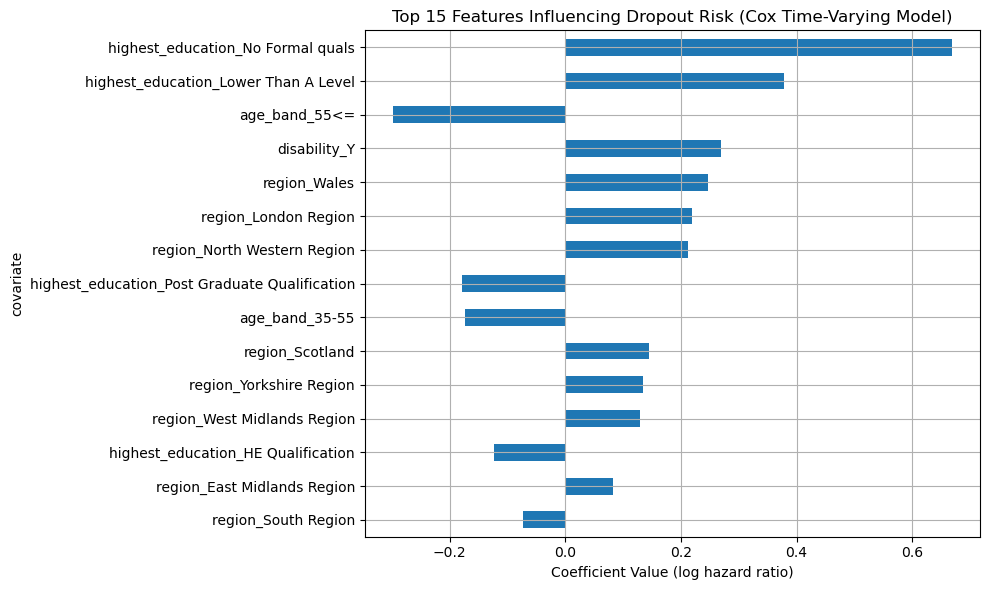

In [13]:
import matplotlib.pyplot as plt

# Get top 15 most impactful coefficients (absolute value)
top_features = ctv.params_.abs().sort_values(ascending=False).head(15).index
top_coefs = ctv.params_[top_features]

# Plot
plt.figure(figsize=(10, 6))
top_coefs.plot(kind='barh')
plt.title("Top 15 Features Influencing Dropout Risk (Cox Time-Varying Model)")
plt.xlabel("Coefficient Value (log hazard ratio)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


Quick Interpretation:
Positive coefficients (right of 0):
→ Increase dropout hazard (i.e., students with this feature are more likely to drop out earlier).
e.g., highest_education_No Formal quals, disability_Y, region_Wales.

Negative coefficients (left of 0):
→ Protective effect — associated with lower risk of dropout.
e.g., highest_education_HE Qualification, age_band_55<=.

In [17]:
# Display the full summary table
pd.set_option('display.max_rows', None)  # Optional: show all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

summary_table


,coef,hazard_ratio,ci_lower,ci_upper,se(coef),p
covariate,,,,,,
clicks,-0.041,0.960,0.957,0.963,0.002,0.000
highest_education_Lower Than A Level,0.378,1.459,1.414,1.505,0.016,0.000
disability_Y,0.269,1.308,1.252,1.367,0.023,0.000
highest_education_No Formal quals,0.669,1.952,1.722,2.213,0.064,0.000
age_band_35-55,-0.174,0.840,0.813,0.869,0.017,0.000
region_Wales,0.247,1.280,1.191,1.375,0.037,0.000
region_London Region,0.219,1.245,1.166,1.328,0.033,0.000
region_North Western Region,0.212,1.237,1.158,1.321,0.034,0.000
highest_education_HE Qualification,-0.123,0.884,0.843,0.928,0.025,0.000


In [18]:
summary_table.to_csv("cox_timevarying_summary.csv", index=True)


In [19]:
from lifelines.utils import concordance_index

# Compute C-index
c_index = concordance_index(
    event_times=tv_df['stop'], 
    predicted_scores=-ctv.predict_partial_hazard(tv_df),  # negate because lower hazard = better survival
    event_observed=tv_df['event']
)

print(f"✅ Concordance Index: {c_index:.4f}")


✅ Concordance Index: 0.5813


In [20]:
# Save coefficients
ctv.params_.to_csv("cox_timevarying_coefficients.csv")

# Save full summary
summary_table.to_csv("cox_timevarying_summary.csv")


In [21]:
# Sort by ID and start time
tv_df = tv_df.sort_values(by=["id", "start"])

# 1. Cumulative Clicks
tv_df["cumulative_clicks"] = tv_df.groupby("id")["clicks"].cumsum()

# 2. Click Difference From Last Week
tv_df["clicks_diff"] = tv_df.groupby("id")["clicks"].diff().fillna(0)

# 3. Rolling Mean Clicks (2-week window)
tv_df["rolling_mean_2w"] = tv_df.groupby("id")["clicks"].rolling(window=2, min_periods=1).mean().reset_index(0, drop=True)


In [ ]:
#diff approach

In [26]:
import pandas as pd
import numpy as np

# --- Step 1: Load raw data ---
student_vle = pd.read_csv('studentVle.csv')
student_info = pd.read_csv('studentInfo.csv')

# --- Step 2: Convert date → week ---
student_vle = student_vle[student_vle['date'].notna()]  # remove missing date rows
student_vle['week'] = (student_vle['date'] // 7).astype(int)

# --- Step 3: Aggregate weekly clicks per student ---
weekly_clicks = student_vle.groupby(['id_student', 'week'])['sum_click'].sum().reset_index()
weekly_clicks.rename(columns={'sum_click': 'clicks'}, inplace=True)

# --- Step 4: Filter early weeks (0–5) ---
early_weeks = weekly_clicks[weekly_clicks['week'] <= 5]

# --- Step 5: Feature engineering ---
# Aggregate engagement stats
engagement_features = early_weeks.groupby('id_student').agg({
    'clicks': ['sum', 'mean', 'std', 'max', 'min'],
    'week': ['nunique']
})
engagement_features.columns = [
    'clicks_sum', 'clicks_mean', 'clicks_std', 'clicks_max', 'clicks_min', 'weeks_active'
]

# Last week active
last_week = early_weeks.groupby('id_student')['week'].max().rename('last_week_active')

# Trend of engagement over time (click slope)
click_trend = early_weeks.groupby(['id_student', 'week'])['clicks'].sum().unstack(fill_value=0)
slope = click_trend.apply(lambda row: np.polyfit(row.index, row.values, 1)[0], axis=1).rename('click_slope')

# Combine all features
early_feats = pd.concat([engagement_features, last_week, slope], axis=1).reset_index()

# --- Step 6: Create survival dataset from student_info ---
# Create binary event column: 1 = dropped out
student_info['event'] = student_info['final_result'].isin(['Withdrawn', 'Fail']).astype(int)

# Assume course duration is last available VLE date
# This can be customized; here we take max date per student
student_vle_duration = student_vle.groupby('id_student')['date'].max().rename('duration').reset_index()

# Merge survival labels
survival_df = pd.merge(student_info[['id_student', 'event']], student_vle_duration, on='id_student', how='left')

# --- Step 7: Merge features and survival data ---
X = pd.merge(survival_df, early_feats, on='id_student', how='left')
X.fillna(0, inplace=True)  # Fill missing values for students with no early engagement

# ✅ Now `X` is ready for Cox model training


In [27]:
from lifelines import CoxPHFitter

# Initialize Cox model with L2 regularization
cph = CoxPHFitter(penalizer=0.1)  # You can tune the penalizer value

# Fit model
cph.fit(X, duration_col='duration', event_col='event')

# Print summary
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 32593 total observations, 15385 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 32593
number of events observed = 17208
   partial log-likelihood = -162883.49
         time fit was run = 2025-07-15 17:10:40 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
id_student       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
clicks_sum       -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
clicks_mean      -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
clicks_std        0.00      1.00      0.00            0.00            0.00                1.00                1.00
clicks_max        0.00      1.00      0.00           -0.00            0.00                1.00                1.00
clicks_min       -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
weeks_active     -0.11      0.90      0.00           -0.12           -0.10                0.89                0.90
last_week_active -0.33      0.72      0.01           -0.34           -0.32                0.71                0.73
click_slope      -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99

                  cmp to      z      p  -log2(p)
covariate                                       
id_student          0.00  -1.12   0.26      1.93
clicks_sum          0.00  -5.11 <0.005     21.54
clicks_mean         0.00  -4.01 <0.005     13.98
clicks_std          0.00   3.61 <0.005     11.65
clicks_max          0.00   0.70   0.49      1.04
clicks_min          0.00  -8.59 <0.005     56.66
weeks_active        0.00 -30.50 <0.005    676.17
last_week_active    0.00 -65.56 <0.005       inf
click_slope         0.00 -11.53 <0.005     99.75
---
Concordance = 0.79
Partial AIC = 325784.97
log-likelihood ratio test = 15708.27 on 9 df
-log2(p) of ll-ratio test = inf

In [28]:
from lifelines.utils import concordance_index

# Evaluate concordance index (C-index)
cindex = concordance_index(X['duration'], -cph.predict_partial_hazard(X), X['event'])
print(f"✅ Concordance Index: {cindex:.4f}")


✅ Concordance Index: 0.7856


<Axes: >

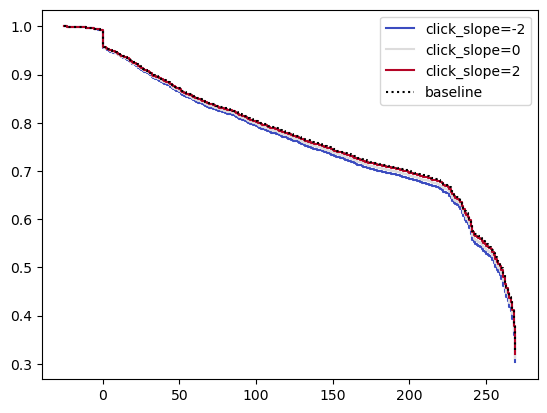

In [29]:
cph.plot_partial_effects_on_outcome(
    covariates='click_slope',
    values=[-2, 0, 2],  # Adjust values based on feature range
    cmap='coolwarm'
)


<Axes: xlabel='log(HR) (95% CI)'>

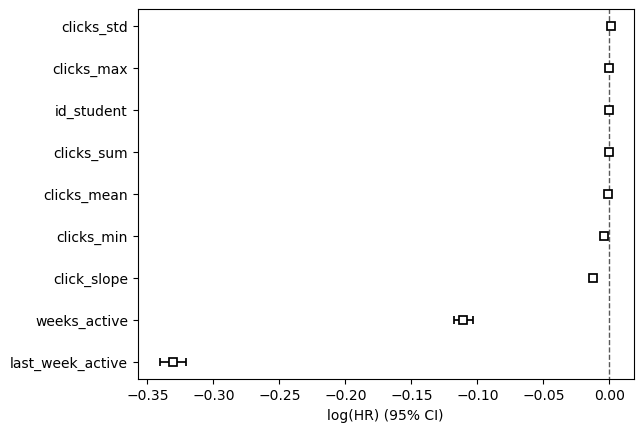

In [30]:
cph.plot()


In [31]:
for p in [0.01, 0.05, 0.1, 0.5, 1.0]:
    model = CoxPHFitter(penalizer=p)
    model.fit(X, duration_col='duration', event_col='event')
    c_idx = concordance_index(X['duration'], -model.predict_partial_hazard(X), X['event'])
    print(f"Penalizer {p}: C-index = {c_idx:.4f}")


Penalizer 0.01: C-index = 0.7880
Penalizer 0.05: C-index = 0.7869
Penalizer 0.1: C-index = 0.7856
Penalizer 0.5: C-index = 0.7797
Penalizer 1.0: C-index = 0.7765


In [32]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Define high vs low early engagement groups
X['active_group'] = X['weeks_active'].apply(lambda x: '≥4 weeks' if x >= 4 else '<4 weeks')


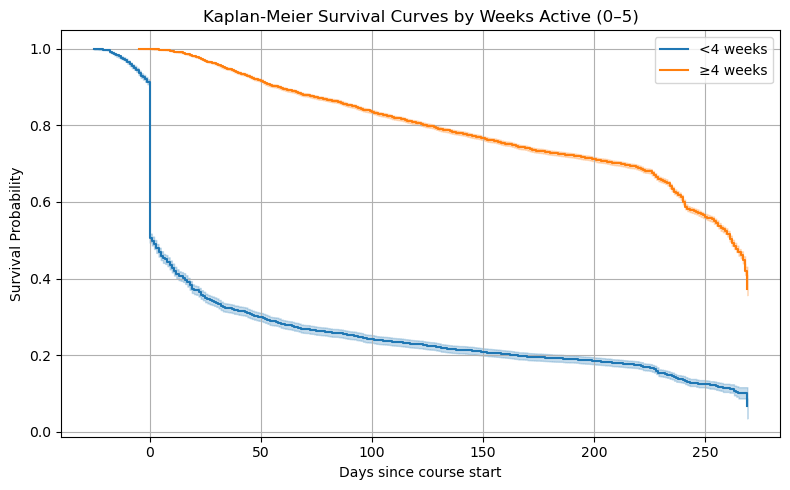

In [33]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 5))

for group, subset in X.groupby('active_group'):
    kmf.fit(durations=subset['duration'], event_observed=subset['event'], label=group)
    kmf.plot_survival_function(ci_show=True)

plt.title('Kaplan-Meier Survival Curves by Weeks Active (0–5)')
plt.xlabel('Days since course start')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
X['slope_group'] = pd.cut(X['click_slope'], bins=[-np.inf, -1, 0, 1, np.inf],
                          labels=['Decline', 'Flat-', 'Flat+', 'Increase'])


In [35]:
from lifelines import KaplanMeierFitter

# Prepare the table
kmf = KaplanMeierFitter()
summary_table = {}

for group, subset in X.groupby('active_group'):
    kmf.fit(subset['duration'], event_observed=subset['event'], label=group)
    summary_table[group] = {
        'Survival@100': kmf.predict(100),
        'Survival@150': kmf.predict(150),
        'Survival@200': kmf.predict(200),
    }

survival_df = pd.DataFrame(summary_table).T.round(3)
print(survival_df)


          Survival@100  Survival@150  Survival@200
<4 weeks         0.242         0.208         0.185
≥4 weeks         0.835         0.766         0.712


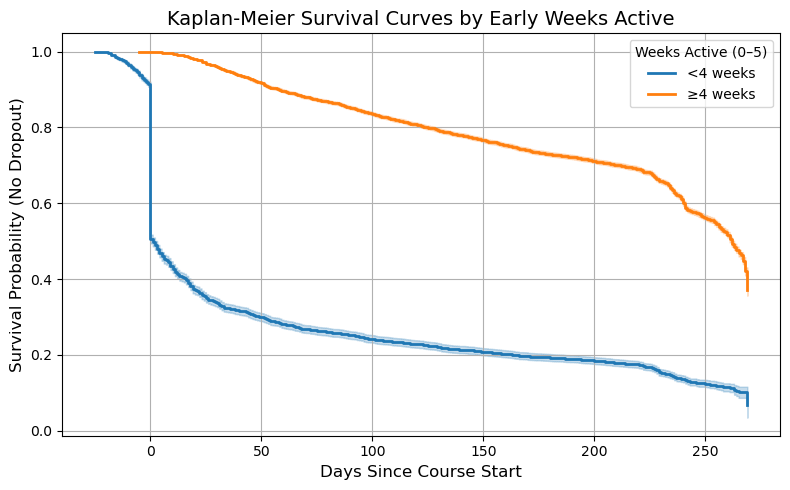

In [36]:
plt.figure(figsize=(8, 5))
for group, subset in X.groupby('active_group'):
    kmf.fit(subset['duration'], event_observed=subset['event'], label=group)
    kmf.plot_survival_function(ci_show=True, lw=2)

plt.title('Kaplan-Meier Survival Curves by Early Weeks Active', fontsize=14)
plt.xlabel('Days Since Course Start', fontsize=12)
plt.ylabel('Survival Probability (No Dropout)', fontsize=12)
plt.legend(title='Weeks Active (0–5)')
plt.grid(True)
plt.tight_layout()

# Save for report
plt.savefig("km_by_weeks_active.png", dpi=300)
plt.show()
